# Applys **gradient ascent** to a **specific label**(particular neuron in the last layer) of **ImageNet** on a **zero input image**.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops
from torch.nn import functional as F
import scipy
import scipy.misc
from scipy import ndimage
import math

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used to run this program: ",device)

Device used to run this program:  cuda


In [0]:
#standard normalization for ImageNet data
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )  

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])


In [44]:
#import a pretrained neural net
net = models.vgg19(pretrained=True)
net.eval()
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
## GAUSSIAN FILTER
# Set these to whatever you want for your gaussian filter

def createGaussianFilter(kernel_size = 3,sigma = 0.45):
  # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
  x_cord = torch.arange(kernel_size)
  x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
  y_grid = x_grid.t()
  xy_grid = torch.stack([x_grid, y_grid], dim=-1)

  mean = (kernel_size - 1)/2.
  variance = sigma**2.

  # Calculate the 2-dimensional gaussian kernel which is
  # the product of two gaussian distributions for two different
  # variables (in this case called x and y)
  gaussian_kernel = (1./(2.*math.pi*variance)) *\
                    torch.exp(
                        -torch.sum((xy_grid - mean)**2., dim=-1) /\
                        (2*variance)
                    )
  # Make sure sum of values in gaussian kernel equals 1.
  gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

  # Reshape to 2d depthwise convolutional weight
  gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
  gaussian_kernel = gaussian_kernel.repeat(3, 1, 1, 1)

  pad = math.floor(kernel_size/2)

  gaussian_filter = nn.Conv2d(in_channels=3, out_channels=3,padding=pad,
                              kernel_size=kernel_size, groups=3, bias=False)

  gaussian_filter.weight.data = gaussian_kernel
  gaussian_filter.weight.requires_grad = False
  gaussian_filter = gaussian_filter.to(device)
  
  return gaussian_filter

In [0]:
l2_norm_coeff = 0.1
l1_norm_coeff = 0.01

In [0]:
def activation_maximizer(image, label, iterations, lr,gaussian_filter): # returns an Image object
  """Does activation maximization on a specific label 
  """  
  img_tensor = preprocess(image)
  img_tensor = img_tensor.to(device)
  image = Variable(img_tensor.unsqueeze(0),requires_grad=True)
  
  
  # offset by the min value to 0 (shift data to positive)
  min_val = torch.min(image.data)
  image.data = image.data - min_val

  # quantile=0.001
  loss_list = []

  for i in range(iterations):
      
      optimizer = torch.optim.SGD([image],lr)
      # out = net(gaussian_filter(image))
      out = net(image)
      if i%20 == 0:
        print(out[0,label].item())
      loss = -out[0,label]
      #loss =  out[0,label]
      
      loss.backward()
      loss_list.append(loss)

      # grayscale the gradients
      mean_grads = image.grad.data.mean(1)
      image.grad.data = torch.stack([mean_grads,]*3,dim=1)
          
      
      optimizer.step()

      image.data = gaussian_filter(image.data) # GAUSS FILTERED
      
      image.grad.data.zero_() # reset gradient of image to 0
        
  image = image.data.squeeze() # remove the batch dimension

  image.transpose_(0,1) # convert from CxHxW to HxWxC format
  image.transpose_(1,2)
  
  image = image.cpu() # back to host
  
  # TRUNCATE TO THROW OFF DATA OUTSIDE 5 SIGMA
  mean = torch.mean(image)
  std = torch.std(image)
  upper_limit = mean + 5 * std
  lower_limit = mean - 5 * std
  image.data = torch.clamp_(image.data,lower_limit,upper_limit)
  
  
  # normalize data to lie between 0 and 1
  image.data = (image.data - lower_limit) / (10*std)
  
  im = Image.fromarray((image.data.numpy()*255).astype('uint8'), 'RGB') #torch tensor to PIL image
  # im = Image.fromarray((image.data.numpy()[:,:,0]*255).astype('uint8'), 'L') #torch tensor to PIL image
  return im,loss_list

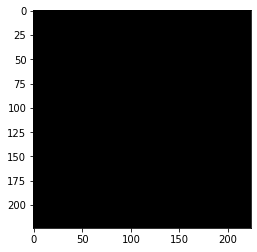

In [48]:
zero_img = np.zeros((224,224,3)) # create a zero image
input_img = Image.fromarray((zero_img).astype('uint8'),'RGB')
plt.imshow(input_img)

In [49]:
input_tensor = preprocess(input_img)
input_tensor = input_tensor.to(device)
input_tensor = Variable(input_tensor.unsqueeze(0),requires_grad=True)
net(input_tensor)

tensor([[-6.3516e-01,  1.5270e+00,  4.4847e-01,  4.3372e-01,  1.1542e+00,
          7.2392e-01, -4.0549e-01, -3.1381e-01, -8.6887e-01,  4.9747e-01,
          9.3966e-02, -3.6258e-01, -9.8047e-01, -1.1213e+00, -1.5126e+00,
         -7.4946e-01, -9.6594e-01, -1.0507e+00, -7.6663e-01, -9.0159e-01,
         -7.1689e-01, -4.6886e-02,  1.0882e+00, -2.6620e-01,  2.3801e-01,
          1.5992e-01,  4.2351e-01, -8.8472e-02,  3.1631e-01,  7.0178e-01,
         -6.4338e-01,  1.7800e+00,  7.2482e-01, -1.1294e-01,  1.3017e+00,
         -9.5165e-01, -8.3464e-02, -1.6822e+00,  1.4885e+00, -1.8739e-01,
          5.1766e-01, -4.7780e-01,  2.9669e-03,  5.6901e-01,  4.8219e-02,
         -6.0994e-01,  3.9827e-01,  7.9569e-01, -6.4478e-01, -3.5523e-01,
         -6.4091e-02,  8.3834e-01,  2.9898e-01,  4.6612e-01,  7.9754e-01,
          7.5143e-01, -3.4561e-01, -1.0278e+00, -7.9010e-01,  2.6400e+00,
          1.7151e+00,  1.7495e-01, -2.1238e-01,  1.6070e+00,  7.1507e-01,
          3.5015e-01,  1.2049e+00, -3.

-0.25559425354003906
1.490814447402954
7.120074272155762
13.692451477050781
41.130638122558594
63.04438400268555
73.72563171386719
86.71939086914062
112.51551055908203
117.82340240478516
122.98777770996094
147.24014282226562
144.23968505859375
145.18765258789062
149.4712677001953
171.01072692871094
160.58450317382812
178.44692993164062
175.7186279296875
167.42250061035156


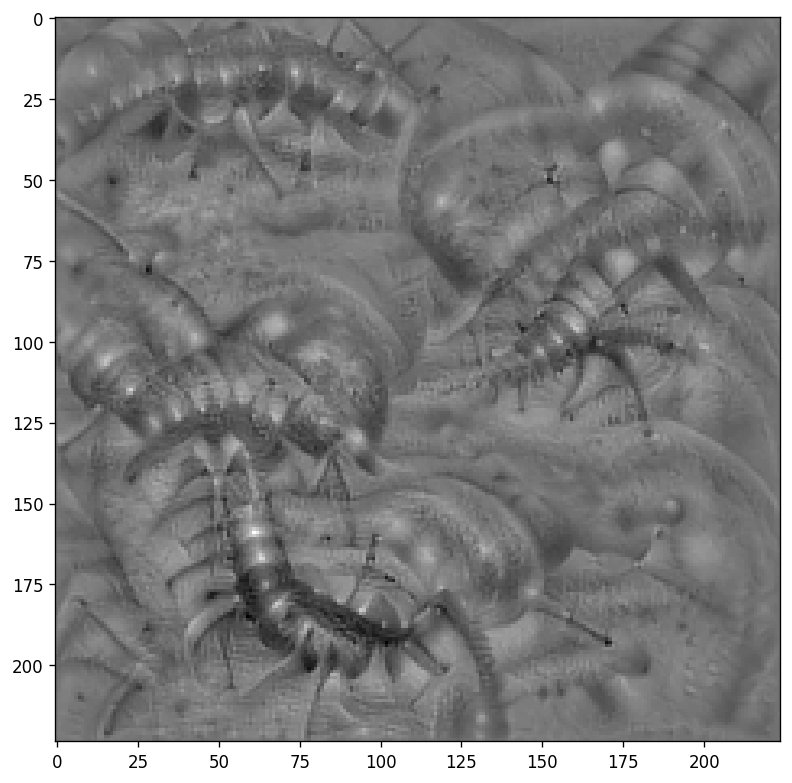

In [51]:
gaussian_filter = createGaussianFilter(3,0.46)
output_img,loss_list = activation_maximizer(input_img,79,400,0.12,gaussian_filter) # maximize activation for input_image, label number, num. of iterations, learning rate
plt.figure(num=1, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(np.asarray(output_img)[:,:,0],cmap='gray')

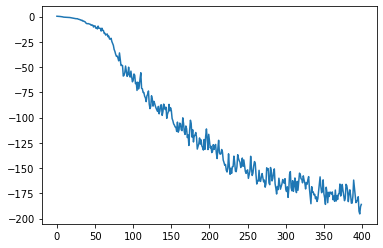

In [52]:
plt.plot(loss_list)
plt.show()